1. Intall dependencies

In [1]:
!pip3 install torch torchvision torchaudio

In [2]:
!pip install stable-baselines3[extra] protobuf==3.20.*

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=15c62645099721163327f6e1adfa5385cc09b8db74c3a268bec61a6f93db1c2c
  Stored in directory: c:\users\sharukh\appdata\local\pip\cache\wheels\b3\50\6c\0a82c1358b4da2dbd9c1bb17e0f89467db32812ab236dbf6d5
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=446447 sha256=ae49a38e47e7c4d7458c109e3521c986783229bf31ed5cf877346edf485b8e56
  Stored in directory: c:\users\sharukh\appdata\local\pip\cache\wheels\2b\03\e4\8b662e95b85786a03898fca125d5a9e3fe49337b1eba8fddd2
Successfully built gym AutoROM.accept-rom-license
  Attempting uninstall: importlib-meta

In [3]:
!pip install pytesseract mss pydirectinput

  Attempting uninstall: packaging
    Found existing installation: packaging 21.0
    Uninstalling packaging-21.0:
      Successfully uninstalled packaging-21.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.


2. Import dependencies

In [4]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete
from tqdm import tqdm
from PIL import Image, ImageEnhance, ImageFilter

3. Build custom game Env

In [139]:
# Create enviornment
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space= Box(low=0,high=255,shape=(1,200,250),dtype=np.uint8)
        self.action_space=Discrete(3)
        self.cap=mss()
        # the coordinates need to be caliberated as per display resolution
        self.game_location={'top':235,'left':0,'width':600,'height':150}
        self.done_location_game={'top':290,'left':320,'width':150,'height':50}
        self.done_location_over={'top':290,'left':490,'width':150,'height':50}
        self.done_reset_btn={'top':277,'left':320,'width':45,'height':40}
        pass
    def step(self,action):
        #action space 0= jump,1= Duck,2= Do Nothing
        action_map = {
            0:'space',
            1:'down',
            2:'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])
        new_observation=self.get_observation()
        done,cap=self.isOver()
        
        reward=1 if not done else -1
        info={}
        return new_observation,reward,done,info 
    def render(self):
        # plt.imshow(self.get_observation()[0])
        cv2.imshow('Game',np.array(self.get_observation()[0]))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
        
        pass
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150,y=150)
        pydirectinput.press('space')
        return self.get_observation()
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]#.astype(np.uint8)
        gray = cv2.cvtColor(raw,cv2.COLOR_BGR2GRAY)
        #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        #gray =  cv2.filter2D(gray, -1, kernel)
        resized = cv2.resize(gray,(250,200))
        channel = np.reshape(resized,(1,200,250))
        return channel
    def close(self):
        cv2.destroyAllWindows()
    def isOver(self):
        # word_game=np.array(self.cap.grab(self.done_location_game))[:,:,:3]
        # word_over=np.array(self.cap.grab(self.done_location_over))[:,:,:3]
        # caption=['GAME','OVER']
        # pytesseract.tesseract_cmd = r'C:\Users\sharukh\anaconda3\Library\bin\tesseract.exe'
        # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        # # word_game = cv2.filter2D(word_game, -1, kernel)
        # # word_over = cv2.filter2D(word_over, -1, kernel)
        # # im = im.filter(ImageFilter.MedianFilter())
        # # enhancer = ImageEnhance.Contrast(im)
        # # im = enhancer.enhance(2)
        # res_game = pytesseract.image_to_string(word_game)[:4]
        # res_over = pytesseract.image_to_string(word_over)[:4]
        # print([res_game,res_over])
        # # return (caption in list(res_game) or caption in list(res_over)),word_game,word_over
        # return (caption[0] in res_game or caption[1] in res_over),word_game,word_over
        reset_btn=cv2.imread("./reset.png")
        capture_reset=np.array(self.cap.grab(self.done_reset_btn))
        errorL2 = cv2.norm( reset_btn[:,:,:3], capture_reset[:,:,:3], cv2.NORM_L2 )
        similarity1 = 1 - errorL2 / ( 47 * 54 )
        reset_btn=cv2.imread("./reset0.png")
        capture_reset=np.array(self.cap.grab(self.done_reset_btn))
        errorL2 = cv2.norm( reset_btn[:,:,:3], capture_reset[:,:,:3], cv2.NORM_L2 )
        similarity2 = 1 - errorL2 / ( 47 * 54 )
        time.sleep(0.1)
        #print(similarity)
        return ((similarity1>0.8) or (similarity2>0.8)),capture_reset
        

3. Test Calliberation

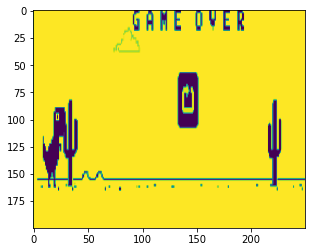

In [131]:
env=WebGame()
plt.imshow(env.get_observation()[0])

True


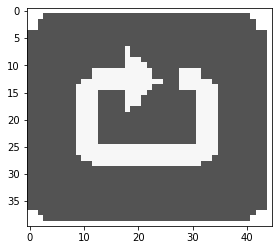

In [132]:
res,game =env.isOver()
print(res)
plt.imshow(game)

In [116]:
env.reset()

array([[[199, 255, 255, ..., 255, 255, 255],
        [199, 255, 255, ..., 255, 255, 255],
        [199, 255, 255, ..., 255, 255, 255],
        ...,
        [200, 255, 255, ..., 255, 255, 255],
        [200, 255, 255, ..., 255, 255, 255],
        [200, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [13]:
env.render()

In [9]:
plt.imshow(over)

NameError: name 'over' is not defined

(40, 45, 4)


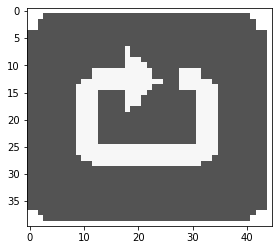

In [94]:
scr=mss()
rst=scr.grab({'top':277,'left':320,'width':45,'height':40})
print(np.array(rst).shape)
plt.imshow(rst)

In [95]:
cv2.imwrite("./reset.png", np.array(rst))

True

In [125]:
for i in range(4):
    rst=scr.grab({'top':277,'left':320,'width':45,'height':40})
    cv2.imwrite(f"./reset{i}.png", np.array(rst))

In [173]:
reset_btn=cv2.imread("./reset.png")
print(reset_btn.shape)
print(np.array(scr.grab({'top':357,'left':453,'width':54,'height':48})).shape)

(48, 54, 3)
(48, 54, 4)


In [182]:
errorL2 = cv2.norm( reset_btn[:,:,:3], np.array(scr.grab({'top':357,'left':453,'width':54,'height':48}))[:,:,:3], cv2.NORM_L2 )
similarity = 1 - errorL2 / ( 48 * 54 )
print('Similarity = ',similarity)

Similarity =  1.0


False


'GARN'

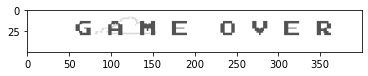

In [43]:
res,isOver,pic =env.isOver()
print(isOver)
plt.imshow(pic)
res

In [118]:
env.action_space.sample()

1

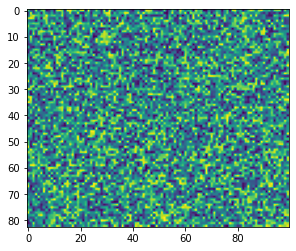

In [113]:
plt.imshow(env.observation_space.sample()[0])

4. Test the custom enviornment

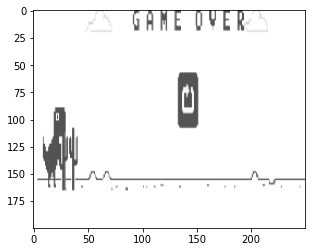

In [140]:
env=WebGame()
obs =env.get_observation()
plt.imshow(cv2.cvtColor(obs[0],cv2.COLOR_BGR2RGB))

In [134]:
done,cap=env.isOver()

In [135]:
done

True

In [141]:
for episode in range(2):
    obs = env.reset()
    done = False
    total_rewards = 0
    while not done:
        obs,reward,done,info =env.step(env.action_space.sample())
        total_rewards += reward
    print(f'Total reward for episode {episode} is {total_rewards}')
        

Total reward for episode 0 is 12
Total reward for episode 1 is 9


5. Train Model

In [142]:
# create Callback

import os

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [143]:
env_checker.check_env(env)

In [146]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self,check_freq,save_path,verbose=1):
        super(TrainAndLoggingCallback,self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path,exist_ok=True)
    def _on_step(self):
        if self.n_calls % self.check_freq==0:
            model_path=os.path.join(self.save_path,'best_model_{}.h5'.format(self.n_calls))
            self.model.save(model_path)
            return True

In [147]:
CHECKPOINT_DIR='./train/'
LOG_DIR='./logs/'

In [148]:
callback=TrainAndLoggingCallback(check_freq=1000,save_path=CHECKPOINT_DIR)

6. Build DQN

In [149]:
from stable_baselines3 import DQN

In [154]:
model=DQN('CnnPolicy',env,tensorboard_log=LOG_DIR,verbose=1,
          buffer_size=90000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\ProgramData\Anaconda3\lib\site-packages\stable_baselines3\common\buffers.py:220: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 9.00GB > 3.75GB
  warnings.warn(


In [155]:
model.learn(total_timesteps=88000,callback=callback)

Logging to ./logs/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 9.25     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 26       |
|    total_timesteps  | 45       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.4     |
|    ep_rew_mean      | 9.38     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 52       |
|    total_timesteps  | 91       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 9.17     |
|    exploration_rate | 0.986    |
| time/               |        

FailSafeException: PyDirectInput fail-safe triggered from mouse moving to a corner of the screen. To disable this fail-safe, set pydirectinput.FAILSAFE to False. DISABLING FAIL-SAFE IS NOT RECOMMENDED.

In [162]:
for episode in range(3):
    obs = env.reset()
    done = False
    total_rewards = 0
    while not done:
        action, _=model.predict(obs)
        obs,reward,done,info =env.step(int(action))
        #time.sleep(0.01)
        total_rewards += reward
    print(f'Total reward for episode {episode} is {total_rewards}')
    #time.sleep(2)
        

Total reward for episode 0 is 20
Total reward for episode 1 is 19
Total reward for episode 2 is 19


In [12]:
import pickle
model.load('train/best_model_88000')

C:\Users\sharukh\anaconda3\lib\site-packages\stable_baselines3\common\buffers.py:220: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 5.70GB
  warnings.warn(


In [12]:
import zipfile
with zipfile.ZipFile('train/best_model_88000.zip', 'r') as zip_ref:
    zip_ref.extractall('train/best_model_88000')

In [13]:
for episode in range(1):
    obs = env.reset()
    done = False
    total_rewards = 0
    while not done:
        action, _=model.predict(obs)
        #print(action)
        obs,reward,done,info =env.step(int(action))
        #time.sleep(0.01)
        total_rewards += reward
    print(f'Total reward for episode {episode} is {total_rewards}')
    #time.sleep(2)

Total reward for episode 0 is 15
